In [22]:
import mmcv
from mmcv import Config
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.models import build_detector
from mmdet.apis import single_gpu_test
from mmcv.runner import load_checkpoint
import os
from mmcv.parallel import MMDataParallel
import pandas as pd
from pandas import DataFrame
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

In [23]:
classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

# config file 들고오기
cfg = Config.fromfile('./custom_configs/cascade_mask_rcnn_swin-l_fpn_giou_ms-crop_3x_coco_aug4.py')

root='../../dataset/'

epoch = 'best_bbox_mAP_50_epoch_19'

# dataset config 수정. mosaic사용 시 모두 comment out
cfg.data.train.classes = classes
cfg.data.train.img_prefix = root
cfg.data.train.ann_file = root + 'train_split.json'

cfg.data.test.classes = classes
cfg.data.test.img_prefix = root
cfg.data.test.ann_file = root + 'val_split.json'
# cfg.data.test.pipeline[1]['img_scale'] = (512,512) # Resize
cfg.data.test.test_mode = True

cfg.data.samples_per_gpu = 8

cfg.seed=42
cfg.gpu_ids = [1]
cfg.fp16 = dict(loss_scale=512.)

cfg.work_dir = './work_dirs/cascade_mask_rcnn_swin-l_fpn_giou_ms-crop_3x_coco_aug3_exp_05-16-15:14:04'
cfg.model.test_cfg.rcnn.nms.iou_threshold = 0.6
cfg.model.test_cfg.rcnn.max_per_image = 1000
cfg.model.test_cfg.rcnn.score_thr = 0.0005
# cfg.work_dir = './weight'

# cfg.model.roi_head.bbox_head.num_classes = 10
# cfg.model.roi_head.bbox_head[0].num_classes = 10 # cascade rcnn
# cfg.model.roi_head.bbox_head[1].num_classes = 10
# cfg.model.roi_head.bbox_head[2].num_classes = 10

cfg.optimizer_config.grad_clip = dict(max_norm=35, norm_type=2)
cfg.model.train_cfg = None

In [4]:
# build dataset & dataloader
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
        dataset,
        samples_per_gpu=1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [5]:
# checkpoint path
checkpoint_path = os.path.join(cfg.work_dir, f'{epoch}.pth')

model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg')) # build detector
checkpoint = load_checkpoint(model, checkpoint_path, map_location='cpu') # ckpt load

model.CLASSES = dataset.CLASSES
model = MMDataParallel(model.cuda(), device_ids=[0])

load checkpoint from local path: ./work_dirs/cascade_mask_rcnn_swin-l_fpn_giou_ms-crop_3x_coco_aug3_exp_05-16-15:14:04/best_bbox_mAP_50_epoch_19.pth


In [6]:
output = single_gpu_test(model, data_loader, show_score_thr=0.0005) # output 계산

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 974/974, 2.6 task/s, elapsed: 382s, ETA:     0s

In [8]:
prediction_strings = []
file_names = []
coco = COCO(cfg.data.test.ann_file)
img_ids = coco.getImgIds()

class_num = 10
for i, out in enumerate(output):
    prediction_string = ''
    image_info = coco.loadImgs(img_ids[i])[0]
    for j in range(class_num):
        for o in out[j]:
            prediction_string += str(j) + ' ' + str(o[4]) + ' ' + str(o[0]) + ' ' + str(o[1]) + ' ' + str(
                o[2]) + ' ' + str(o[3]) + ' '
        
    prediction_strings.append(prediction_string)
    file_names.append(image_info['file_name'])

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [9]:
class_list = dataset.CLASSES

In [10]:
def bbox_iou(bbox_a, bbox_b):
    if bbox_a.shape[1] != 4 or bbox_b.shape[1] != 4:
        raise IndexError

    #bbox_a 1개와 bbox_b k개를 비교해야하므로 None을 이용해서 차원을 늘려서 연산한다.
    # top left
    tl = np.maximum(bbox_a[:, None, :2], bbox_b[:, :2])
    # bottom right
    br = np.minimum(bbox_a[:, None, 2:], bbox_b[:, 2:])

    area_i = np.prod(br - tl, axis=2) * (tl < br).all(axis=2)
    area_a = np.prod(bbox_a[:, 2:] - bbox_a[:, :2], axis=1)
    area_b = np.prod(bbox_b[:, 2:] - bbox_b[:, :2], axis=1)
    return area_i / (area_a[:, None] + area_b - area_i)

In [11]:
no_detects = []
for i, pred_string in enumerate(prediction_strings):
    pred_string = pred_string[:-1].split(' ')
    pred_string = [float(n) for n in pred_string]
    pred_array = np.array(pred_string).reshape(-1, 6)
    gt = dataset.get_ann_info(idx=i)['bboxes']
    gt_labels = dataset.get_ann_info(idx=i)['labels']
    img_path= file_names[i]
    
    ious = bbox_iou(gt, pred_array[:, 2:]) > 0.5
    for gt_idx, (gt_point, gt_label) in enumerate(zip(gt, gt_labels)):
        ious_onebox = ious[gt_idx:gt_idx+1].transpose()
        pred_with_tf = np.array(sorted(np.concatenate((pred_array, ious_onebox), axis=1), key=lambda x: (x[0], -x[1])))
        
        pred_label_indices = np.where(pred_with_tf[:, 0] == gt_label)
        for cls, conf_score, xmin_iou, ymin_iou, xmax_iou, ymax_iou, tf in pred_with_tf[pred_label_indices]:
            no_detect = True
            if tf > 0.5:
                no_detect = False
                break
        if no_detect:
            no_detects.append([img_path, gt_label, *gt_point])
            
no_detects = np.array(no_detects)

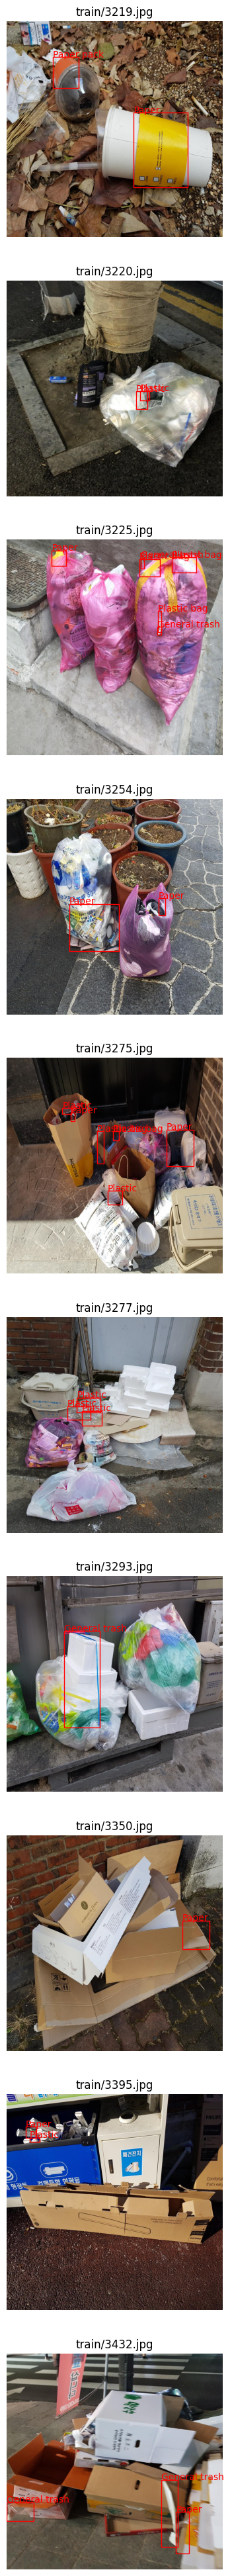

In [21]:
k = 7
fig, ax = plt.subplots(10, 1)
fig.set_figheight(50)
fig.set_figwidth(10)
for i in range(k*10, (k+1)*10):
    img_path = np.unique(no_detects[:, 0])[k*10+i]
    no_detects_oneimg = np.where(no_detects[:, 0] == img_path)
    no_detects_oneimg = no_detects[no_detects_oneimg]
    img = cv2.imread("../../dataset/"+img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    ax[i-k*10].set_title(img_path)
    ax[i-k*10].imshow(img)
    # ax[i][1].imshow(img)
    
    ax[i-k*10].axis('off')
    # ax[i][1].axis('off')
    
    for _, class_idx, *points in no_detects_oneimg:
        points = [float(p) for p in points]
        xmin, ymin, xmax, ymax = points
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='red', facecolor='none')
        ax[i-k*10].add_patch(rect)
        ax[i-k*10].text(xmin, ymin, class_list[int(class_idx)], color='red')
    if i == 9:
        break

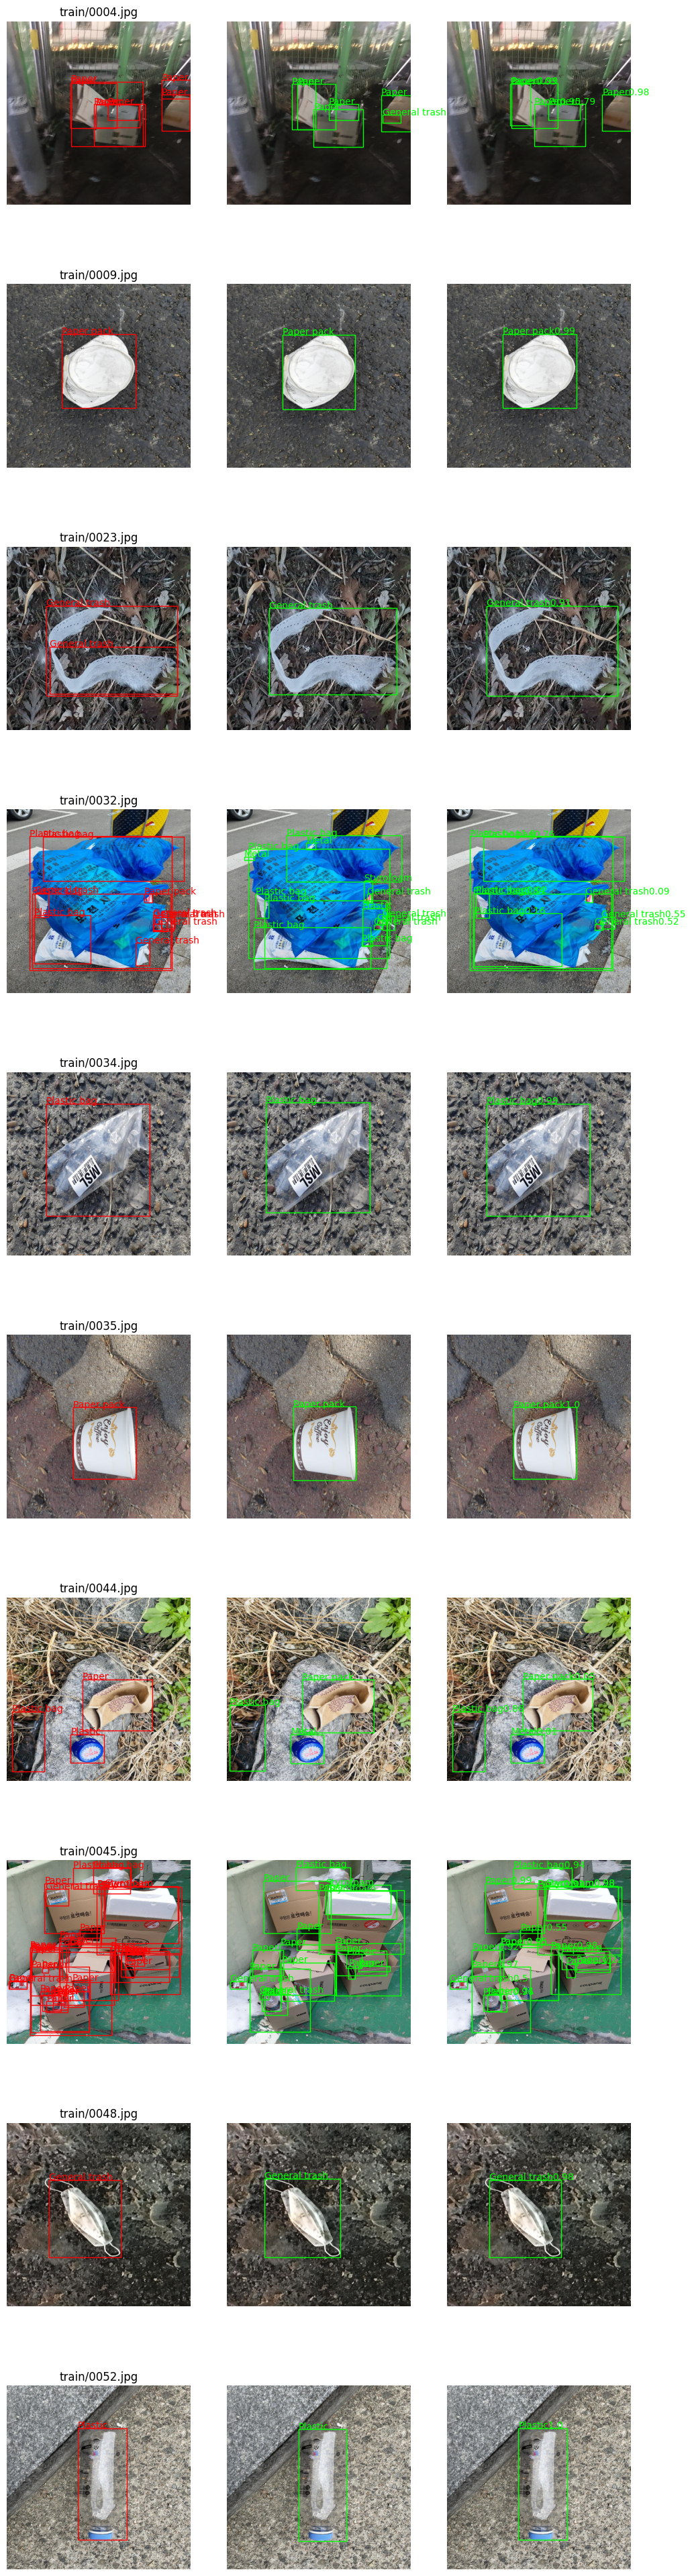

In [119]:
# check with 10 images
k = 0
fig, ax = plt.subplots(10, 3)
fig.set_figheight(50)
fig.set_figwidth(12)
score_thr = 0.3
for i in range(10*k, 10*(k+1)):
    # class_id, conf_score, xmin, ymin, xmax, ymax = pred_string[:-1].split(' ')
    pred_string = prediction_strings[i]
    pred_string = pred_string[:-1].split(' ')
    pred_string = [float(n) for n in pred_string]
    pred_array = np.array(pred_string).reshape(-1, 6)
    gt = dataset.get_ann_info(idx=i)['bboxes']
    gt_labels = dataset.get_ann_info(idx=i)['labels']
    img_path= file_names[i]
    img = cv2.imread("../../dataset/"+img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[i-(k*10)][0].set_title(img_path)
    ax[i-(k*10)][0].imshow(img)
    ax[i-(k*10)][1].imshow(img)
    ax[i-(k*10)][2].imshow(img)
    
    ax[i-(k*10)][0].axis('off')
    ax[i-(k*10)][1].axis('off')
    ax[i-(k*10)][2].axis('off')
    while pred_string != []:
        class_id, conf_score, xmin, ymin, xmax, ymax, *pred_string = pred_string
        if conf_score >= score_thr:
            rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='red', facecolor='none')
            ax[i-(k*10)][0].add_patch(rect)
            ax[i-(k*10)][0].text(xmin, ymin, class_list[int(class_id)], color='red')
        # print(class_id, conf_score, xmin, ymin, xmax, ymax)
    # print(class_id, conf_score, xmin, ymin, xmax, ymax)
    # print(gt)
    # break
    
    ious = bbox_iou(gt, pred_array[:, 2:]) > 0.5
    for gt_idx, (gt_point, gt_label) in enumerate(zip(gt, gt_labels)):
        ious_onebox = ious[gt_idx:gt_idx+1].transpose()
        # print(ious_onebox)
        pred_with_tf = np.array(sorted(np.concatenate((pred_array, ious_onebox), axis=1), key=lambda x: (x[0], -x[1])))
        
        xmin, ymin, xmax, ymax = gt_point
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='#00FF00', facecolor='none')
        ax[i-(k*10)][1].add_patch(rect)
        ax[i-(k*10)][1].text(xmin, ymin, class_list[gt_label], color='#00FF00')
        
        pred_label_indices = np.where(pred_with_tf[:, 0] == gt_label)
        for cls, conf_score, xmin_iou, ymin_iou, xmax_iou, ymax_iou, tf in pred_with_tf[pred_label_indices]:
            if tf > 0.5:
                rect = patches.Rectangle((xmin_iou, ymin_iou), xmax_iou-xmin_iou, ymax_iou-ymin_iou, linewidth=1, edgecolor='#00FF00', facecolor='none')
                ax[i-(k*10)][2].add_patch(rect)
                ax[i-(k*10)][2].text(xmin_iou, ymin_iou, class_list[int(cls)] + str(round(conf_score, 2)), color='#00FF00')
                break

--------------

In [24]:
# build dataset & dataloader
dataset_train = build_dataset(cfg.data.train)

loading annotations into memory...
Done (t=0.28s)
creating index...
index created!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([992, 896, 3])


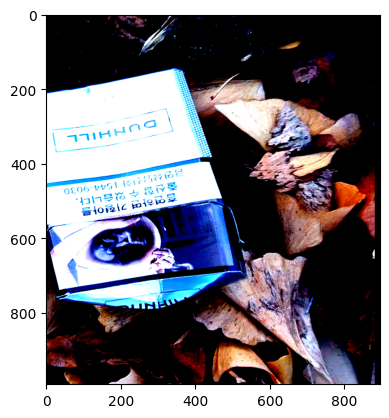

In [28]:
train_sample = dataset_train[21]
print(train_sample['img']._data.permute(1, 2, 0).shape)
plt.imshow(train_sample['img']._data.permute(1, 2, 0))